In [89]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [90]:
import config
from pathlib import Path
import shutil

import keras
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
from tensorflow import data as tf_data

In [91]:
data_path = config.NOTE_NUM_RECOGNITION_DATASET / "data"

In [92]:
image_size = (20, 20)
batch_size = 128

## Generate a Dataset

In [93]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    str(data_path),
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)

Found 37675 files belonging to 63 classes.
Using 30140 files for training.
Using 7535 files for validation.


In [94]:
class_names = train_ds.class_names
print(class_names)

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '64', '7', '8', '9']


In [95]:
def class_distribution(data):
    all_labels = []

    # Iterate through the dataset to collect all labels
    for _, labels in data:
        all_labels.append(labels.numpy())  # Convert Tensors to NumPy and store
    
    # Concatenate all labels into a single NumPy array
    all_labels = np.vstack(all_labels)
    
    # Sum up the labels array across the batch dimension to get class counts
    class_counts = all_labels.sum(axis=0)
    class_names_and_count = list(zip(map(int, data.class_names), class_counts))
    sorted_class_names_and_count = sorted(class_names_and_count, key=lambda c: c[0])
    class_names, class_counts = zip(*sorted_class_names_and_count)
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Instanbces')
    plt.title('Class Distribution')
    # plt.xticks(class_names)  # Ensure all class labels are shown
    plt.show()

In [96]:
ord('1'), ord('2')

(49, 50)

2024-05-14 12:39:11.104825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


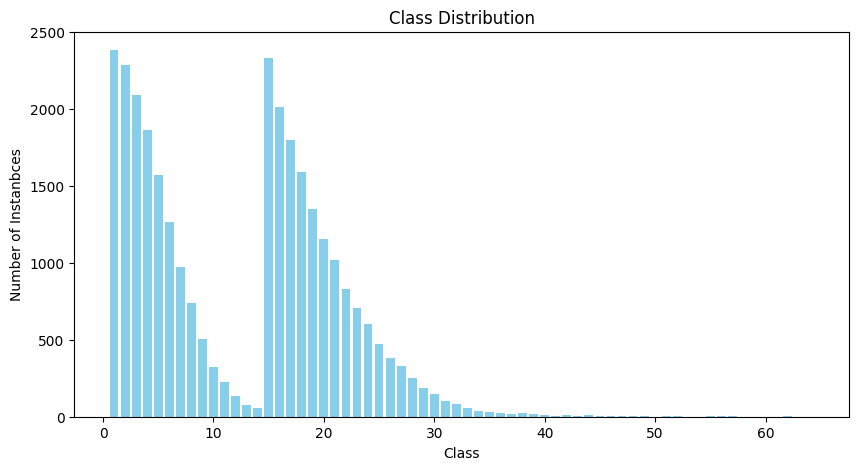

In [97]:
class_distribution(train_ds)

## Visualize the data

2024-05-14 12:39:23.365359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


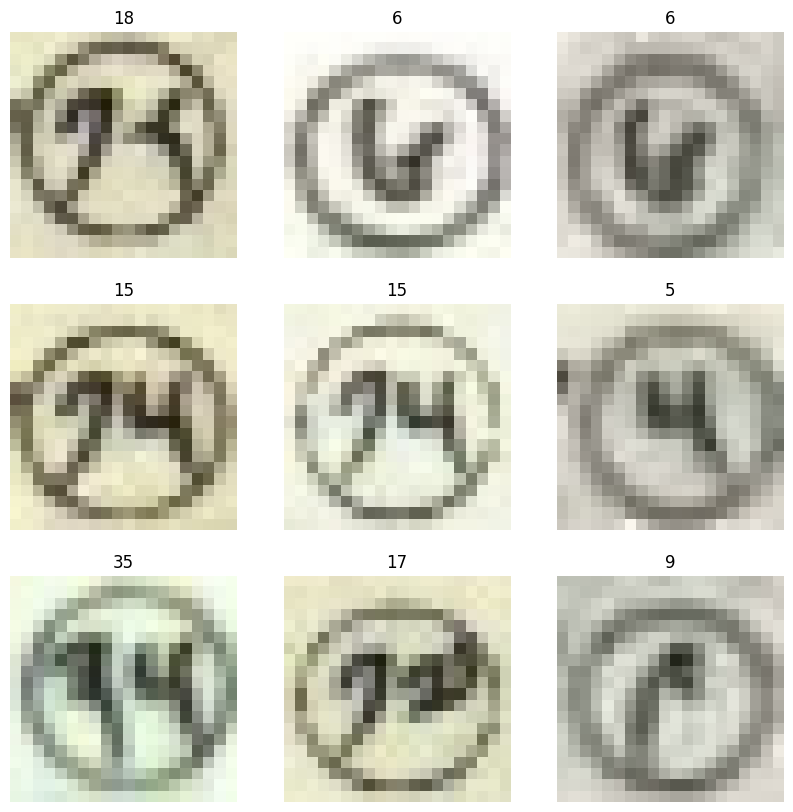

In [98]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        class_index = np.argmax(labels[i])
        plt.title(class_names[class_index])
        plt.axis("off")

## Data Augmentation

In [99]:
data_augmentation_layers = [
    layers.RandomContrast(0.3),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2024-05-14 12:39:27.426894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


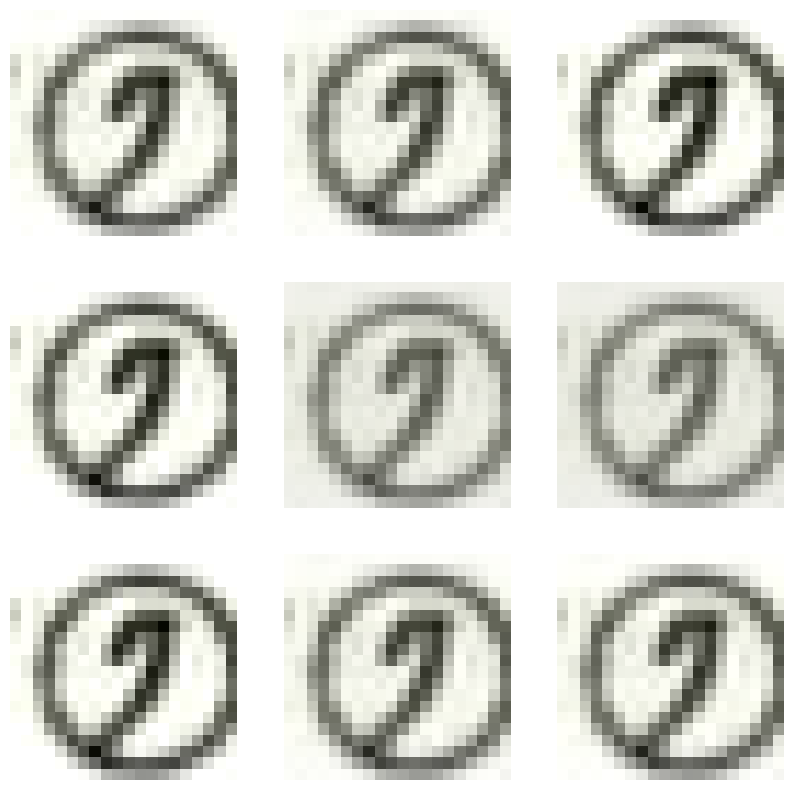

In [100]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [101]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

In [102]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build Model

In [103]:
def make_model(input_shape, num_classes):
    units = 1 if num_classes <= 2 else num_classes
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Rescaling(1.0 / 255),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(units, activation="softmax"),
        ]
    )
    return model

model = make_model(input_shape=image_size + (3,), num_classes=len(class_names))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 63)             │        36,351 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,743 (217.75 KB)

 Trainable params: 55,743 (217.75 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [104]:
epochs = 20

In [105]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [106]:
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2469 - loss: 2.8338 - val_accuracy: 0.9218 - val_loss: 0.4210
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8853 - loss: 0.4767 - val_accuracy: 0.9687 - val_loss: 0.1542
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9503 - loss: 0.2192 - val_accuracy: 0.9837 - val_loss: 0.0819
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9679 - loss: 0.1394 - val_accuracy: 0.9898 - val_loss: 0.0631
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9791 - loss: 0.1007 - val_accuracy: 0.9919 - val_loss: 0.0525
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9835 - loss: 0.0767 - val_accuracy: 0.9939 - val_loss: 0.0464
Epoch 7/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9867 - loss: 0.0659 - val_accuracy: 0.9950 - val_loss: 0.0433
Epoch 8/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9895 - loss: 0.0565 - val_accu

## Inference

In [107]:
import random

In [108]:
def get_num_image():
    data_path = config.NOTE_NUM_RECOGNITION_DATASET/"data"
    num_dir = random.choice(list(data_path.iterdir()))
    return random.choice(list(num_dir.glob("*.jpg")))

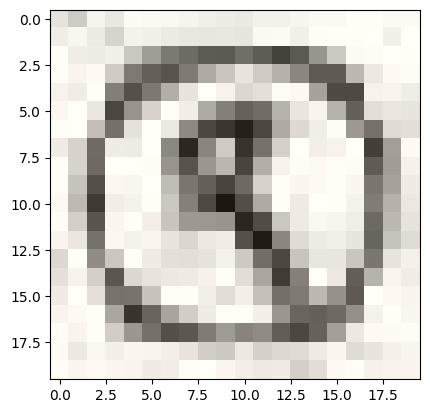

2


In [109]:
def inference(image_path, model, image_size=image_size, imshow=False):
    img = keras.utils.load_img(str(image_path), target_size=image_size)
    if imshow: plt.imshow(img); plt.show()
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array, verbose=0)
    return np.argmax(predictions[0])

image_path = get_num_image()
class_name_idx = inference(image_path, model, imshow=True)
print(class_names[class_name_idx])

## Save Model

In [110]:
model_path = Path("models") / "note_num_recognition" / "note_num_recognition.keras"
model.save(model_path)

## Classify data set

In [111]:
model_path = Path("models") / "note_num_recognition" / "note_num_recognition.keras"
data_path = config.NOTE_NUM_RECOGNITION_DATASET/"data"

In [112]:
loaded_model = keras.saving.load_model(model_path)

In [119]:
class_dir = data_path / "21"
total_note_count = 0
failed_note_count = 0
failed_note_names = ""
for note_img_fn in class_dir.iterdir():
    if not note_img_fn.name.endswith(".jpg"): continue
    total_note_count += 1
    class_name_idx = inference(note_img_fn, model)
    class_name = class_names[class_name_idx]
    if class_name != class_dir.name:
        if class_name == "18": continue
        # dst_note_img_fn = data_path / class_name / note_img_fn.name
        # shutil.move(str(note_img_fn), str(dst_note_img_fn))
        failed_note_count += 1
        failed_note_names += f"\t- {note_img_fn.parent.name}/{note_img_fn.name} Pred Note({class_name})\n"
print(f"Note({class_dir.name}) failed ratio: {round(failed_note_count/total_note_count, 2)}")
print(failed_note_names)

Note(21) failed ratio: 0.01
	- 21/21_W1PD96682_I1PD967940206.jpg Pred Note(22)
	- 21/21_W1PD96682_I1PD967940238.jpg Pred Note(22)
	- 21/21_W1PD96682_I1PD967840317.jpg Pred Note(22)
	- 21/21_W1PD96682_I1PD967920811.jpg Pred Note(23)
	- 21/21_W1PD96682_I1PD967920810.jpg Pred Note(22)
	- 21/21_W1PD96682_I1PD967940116.jpg Pred Note(22)
	- 21/21_W1PD96682_I1PD967940261.jpg Pred Note(22)
	- 21/21_W1PD96682_I1PD967940120.jpg Pred Note(22)
	- 21/21_W1PD95844_I1PD958461462.jpg Pred Note(31)
	- 21/21_W1PD96682_I1PD968860329.jpg Pred Note(20)
	- 21/21_W1PD96682_I1PD967940251.jpg Pred Note(22)
	- 21/21_W1PD96682_I1PD967940245.jpg Pred Note(22)
	- 21/21_W1PD96682_I1PD967860156.jpg Pred Note(22)

